# Q-Learning Algorithm 

## - using Temporal Difference
## - with $\epsilon$ greedy exploration

### Tested on Taxi-v3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict
import random, math
import numpy as np
%matplotlib inline

## Algorithm details - 

#### 1. Initlialize Q(s,a) with all zeros
#### 2. Using the current Q(s,a) get the best action to take by following - 

##### 2.a - Get value function at current state, V(s) by -
$$V(s) =   \max_a Q(s,a)$$

##### 2.b - Get the new Q function using -
$$ \hat Q(s_t,a_t) = r + \gamma*V(s_t+1)$$

##### 2.c - Smooth update of Q function using moving average -
$$Q(s_t,a_t)=\alpha*(\hat Q(s_t,a_t)) + (1-\alpha)*Q(s_t,a_t)$$
Where, $\alpha$ is the learning rate

##### 2.d - Get the best action using - 
$$\pi^*(s) = argmax_a Q(s,a)$$

#### 3 - $\epsilon$ - greedy exploration -
Take a random action with probability $\epsilon$, otherwise use best action


In [2]:
class QLearningAgent:
    
    #Step 1
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #Step 2.a
    def get_value(self, state):
        """
        V(s) = max_over_action Q(state,action) over possible actions.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #Go over all possible actions for the given state
        #Take max to get V* basically
        q_actions = []
        for action in possible_actions:
            q_actions.append(self.get_qvalue(state, action))
        value = np.max(q_actions)

        return value

    #Steps 2.b, 2.c
    def update(self, state, action, reward, next_state):
        """
        Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        
        #Get new_q first using V(s')
        new_q = reward + gamma*self.get_value(next_state)
        #Get moving averaged q_func with new_q and the older q_value
        q_func_avg = learning_rate*new_q + (1-learning_rate)*self.get_qvalue(state, action)

        self.set_qvalue(state, action, q_func_avg)

    #Step 3
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #Best action is the argmax over the new functions
        q_actions = []
        for action in possible_actions:
            q_actions.append(self.get_qvalue(state, action))
        best_action = possible_actions[np.argmax(q_actions)]
            
        return best_action

    #Step 4
    def get_action(self, state):
        """
        Taking into account E-Greedy Exploration!
        """
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        ore_or_oit = np.random.choice([0,1], p =[epsilon, 1-epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(possible_actions) #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = self.get_best_action(state)
            
        return chosen_action

# Train Time

In [3]:
#Open environment
try:
    env = gym.make('Taxi-v3')
except gym.error.DeprecatedEnv:
    # Taxi-v2 was replaced with Taxi-v3 in gym 0.15.0
    env = gym.make('Taxi-v2')

n_actions = env.action_space.n

In [4]:
#Create the agent
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [5]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function runs a full game till t_max
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 2.9191091959171894e-05 mean reward = 6.8


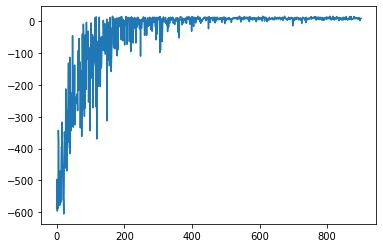

In [6]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    
    #Reduce the exploration over time
    agent.epsilon *= 0.99
    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
        

In [7]:
#Display
total_reward = 0.
s = env.reset()

for t in range(1000):
    #sample action from policy
    a = agent.get_action(s)
    new_s, r, done, info = env.step(a)
    env.render()
    total_reward += r

    s = new_s
    if done:
        break
print("Total Reward: ", total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Total Reward:  11.0
